In [1]:
import numpy as np
import random 
import os

from matplotlib import colors
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader, sampler
from torch.autograd import Variable
import itertools

from model import *

In [2]:
def generate_forecast(scar_mask, input_frames, model, time_forecast=6, k_delay=4):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    x_mask_test = np.array([scar_mask])
    x_mask_test = Variable(torch.from_numpy(x_mask_test)).unsqueeze(0).to(device)
    x_mask_test = torch.sign(x_mask_test)
    
    x_frames_test = Variable(torch.from_numpy(input_frames)).unsqueeze(0).to(device)
    
    Vt_test = x_frames_test[:,:k_delay].clone()
    
    X_in_test = x_frames_test[:,:k_delay].clone()
    
    imgs_test = []

    for t in range(time_forecast):

        X_in_mask_test = torch.cat([x_mask_test, X_in_test], dim=1)

        X_out_test = model(X_in_mask_test)
        
        imgs_test.append(X_out_test[:,1].data.cpu().numpy())

        Vt_test = torch.cat([Vt_test, X_out_test[:,[1]]], 1)
        It_test = Vt_test[:,-k_delay:].clone()
        
        X_in_test = It_test
    
    return np.array(imgs_test)[:,0,]

def plot_imgs(list_of_img, title = '', nb_col = 2, figsize = (15,15), 
              plot_colorbar = False, normaliz = None, 
              mask_fr=False, p=0, start_fr=0):
    
    len_list_of_img = len(list_of_img)
    
    if (len_list_of_img*1. % nb_col):
        nb_row = int((len_list_of_img*1./nb_col)+1)
    else :
        nb_row = int(len_list_of_img*1./nb_col)
    
    fig, axs = plt.subplots(nrows=nb_row, ncols=nb_col, 
                            figsize=figsize)
    axs_n = np.reshape(axs, (nb_row, nb_col)) ### to avoid 1 shape error
    
    fig.suptitle(title, y=.95, fontsize=20)
    
    for i in range(len_list_of_img): 
        if normaliz == 'norm' :
            norm = colors.Normalize(vmin=0., vmax=1.)
        elif normaliz == 'max' :
            vmin = min(image.min() for image in list_of_img)
            vmax = max(image.max() for image in list_of_img)*1./2
            norm = colors.Normalize(vmin=vmin, vmax=vmax)
        else:
            norm=None
        
        j,k = (int(i / nb_col), int(i % nb_col))
        im = axs_n[j, k].imshow(list_of_img[i], norm = norm)
        
        if i==0:
            if mask_fr:
                axs_n[j, k].set_title('Scar mask', fontsize=16)
                p=1
            else:
                axs_n[j, k].set_title('{} ms'.format(start_fr), fontsize=16)
        else:
            axs_n[j, k].set_title('{} ms'.format(start_fr+i-p), fontsize=16)
                
        axs_n[j, k].set_axis_off()
        
        if plot_colorbar:
            plt.colorbar(im,ax=axs_n[j, k])
        
    plt.show()   

In [3]:
### Load an example of image frames 

path_data = 'data/rectangular_scar/'
mask_frame = np.load(path_data+'scar_mask.npy')

img_frames = []
for i in range(26):
    name_img = 'onset_{}ms.npy'.format(i)
    img_frames.append(np.load(path_data+name_img))
img_frames = np.array(img_frames)

In [4]:
### Load the trained model 
### In this example : ResNet(5,1) with reflect padding in Euler integration scheme

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

padding_type = 'reflect'
NN_dyn = Resnet_2D(input_nc=5,output_nc=1, ngf=25, norm_layer=nn.BatchNorm2d,
                    n_blocks=3, n_downsampling=2, padding_type=padding_type
                     ).to(device)

NN_psi = Integrate(NN_dyn,order=1,n_steps=1,dt=1.0).to(device)

NN_psi.load_state_dict(torch.load('trained_models/Euler_w_Resnet_w_reflect_padd'))

NN_psi.eval();


------Initiating ResNet------



##  Basic example (scar of rectangular shape)

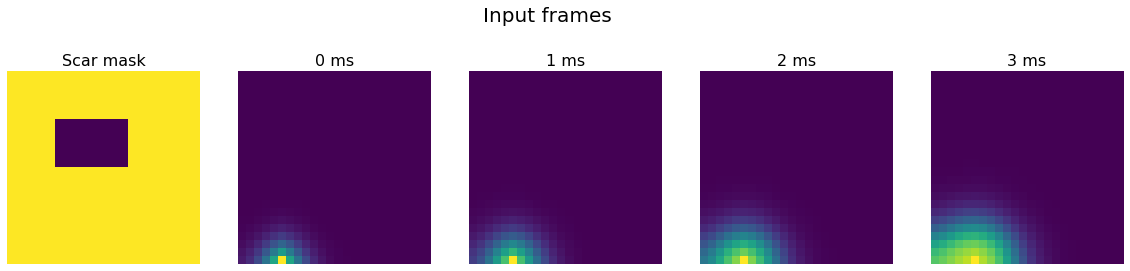

In [5]:
### Get input frames
start_fr = 0
test_frames_input = img_frames[start_fr:start_fr+4]


### Plot all input frames
test_frames_plot = np.concatenate(([mask_frame],
                                   test_frames_input)
                                 )
plot_imgs(test_frames_plot, nb_col = 5, figsize = (20,5), normaliz = 'norm', 
          title='Input frames', mask_fr=True, start_fr=start_fr)

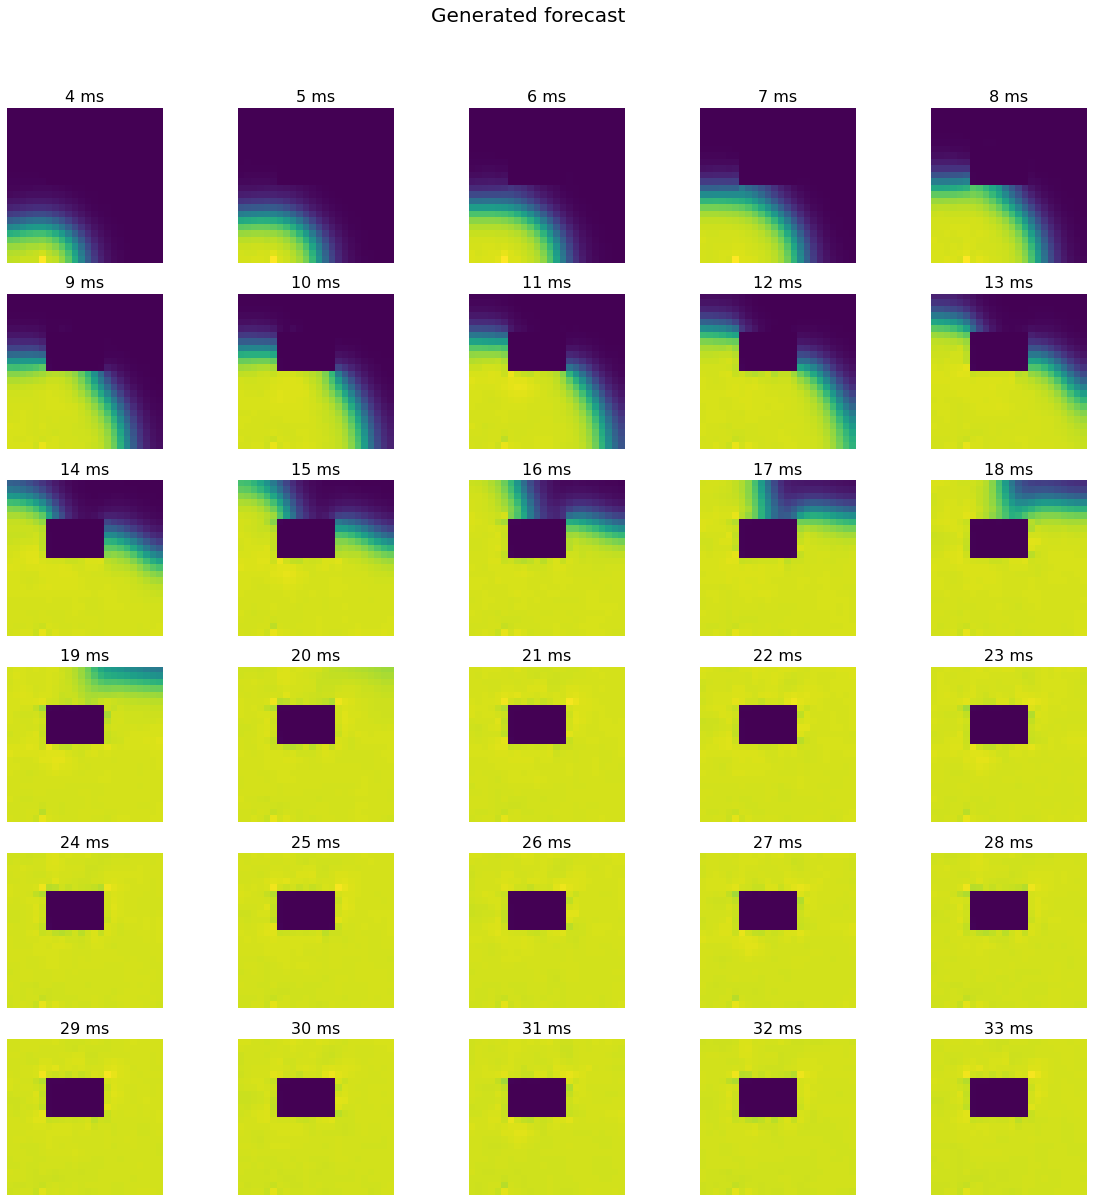

In [6]:
test_forecast_fake = generate_forecast(mask_frame, test_frames_input, 
                                       NN_psi, time_forecast=30)

plot_imgs(test_forecast_fake, nb_col = 5, figsize = (20,20), normaliz = 'norm', 
          title='Generated forecast', start_fr=start_fr+4)

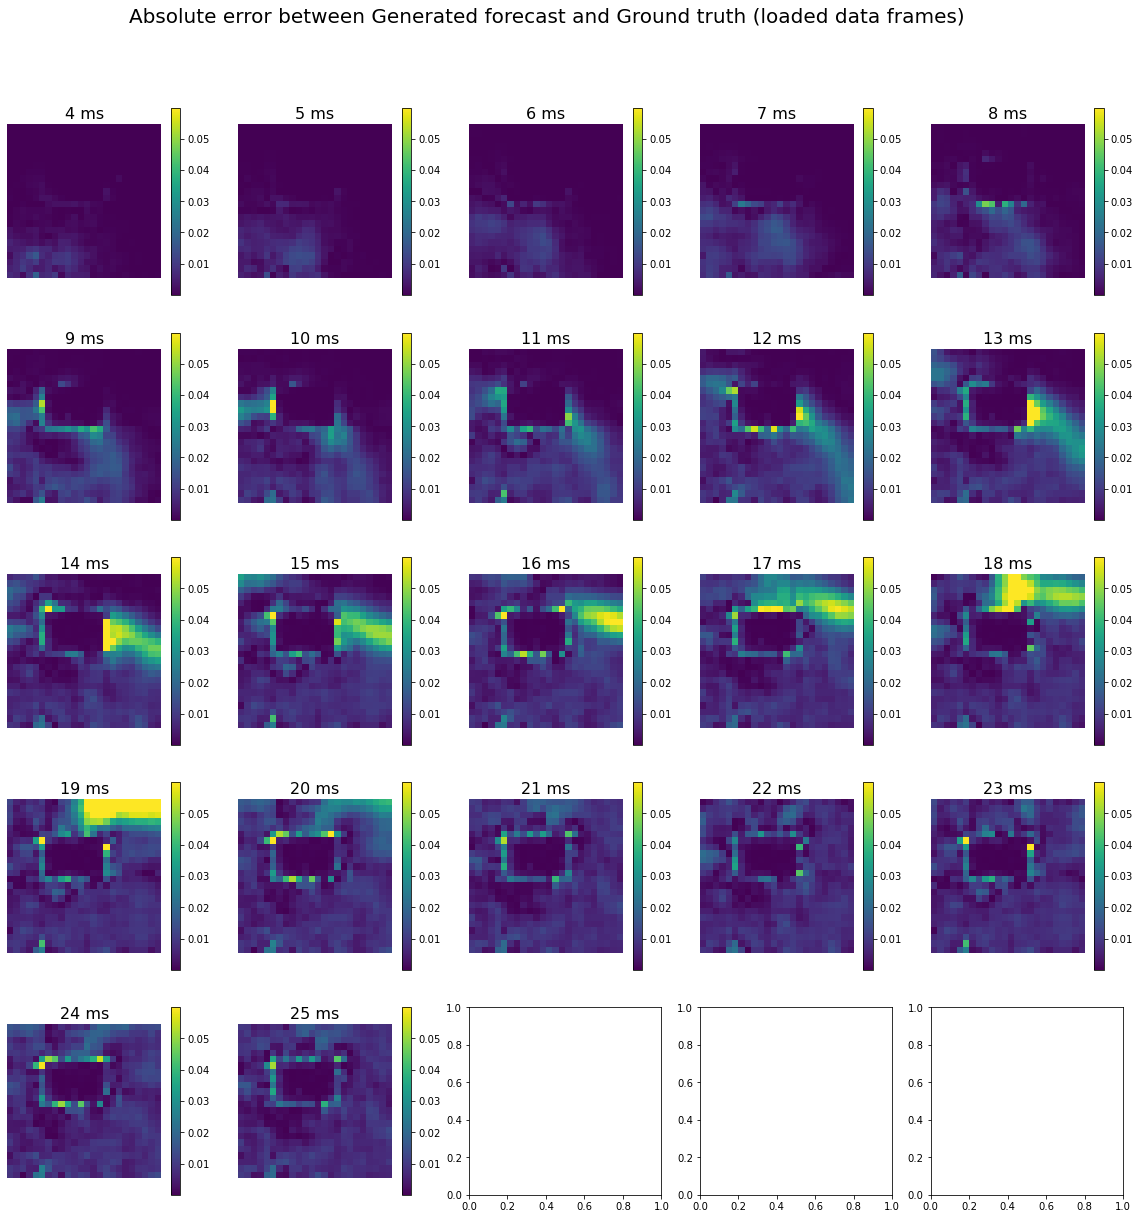

In [7]:
### Only 26 frames (ms) of Ground truth are available
plot_imgs(abs(img_frames[4+start_fr:]-test_forecast_fake[0:22-start_fr]), nb_col = 5, 
          figsize = (20,20), normaliz = 'max', plot_colorbar = True, start_fr=start_fr+4,
          title='Absolute error between Generated forecast and Ground truth (loaded data frames)')

##  New example (scar of custom shape)

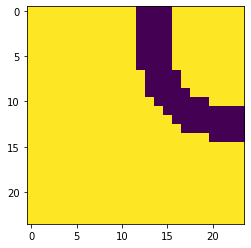

In [8]:
### For examlpe : of circular shape
n = mask_frame.shape[0]
new_mask = np.ones((n, n), dtype=np.float32)

# draw the circle
centre_x, centre_y = 23,3
radius = 10
EPSILON = 6
for y in range(0,n):
    for x in range(0,n):
        # see if we're close to (x-a)**2 + (y-b)**2 == r**2
        if abs((x-centre_x)**2 + (y-centre_y)**2 - radius**2) <= EPSILON**2:
            new_mask[y][x] = 0

plt.imshow(new_mask);

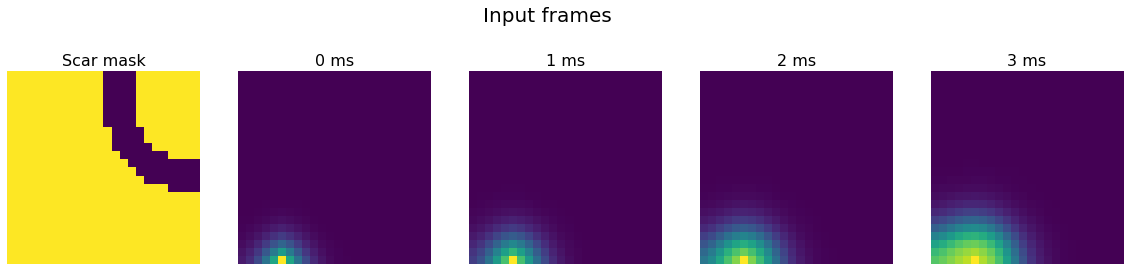

In [9]:
### Get input frames
start_fr_new = 0
test_frames_input_new = img_frames[start_fr_new:start_fr_new+4]


### Plot all input frames
test_frames_plot_new = np.concatenate(([new_mask],
                                   test_frames_input_new)
                                 )
plot_imgs(test_frames_plot_new, nb_col = 5, figsize = (20,5), normaliz = 'norm', 
          title='Input frames', mask_fr=True, start_fr=start_fr_new)

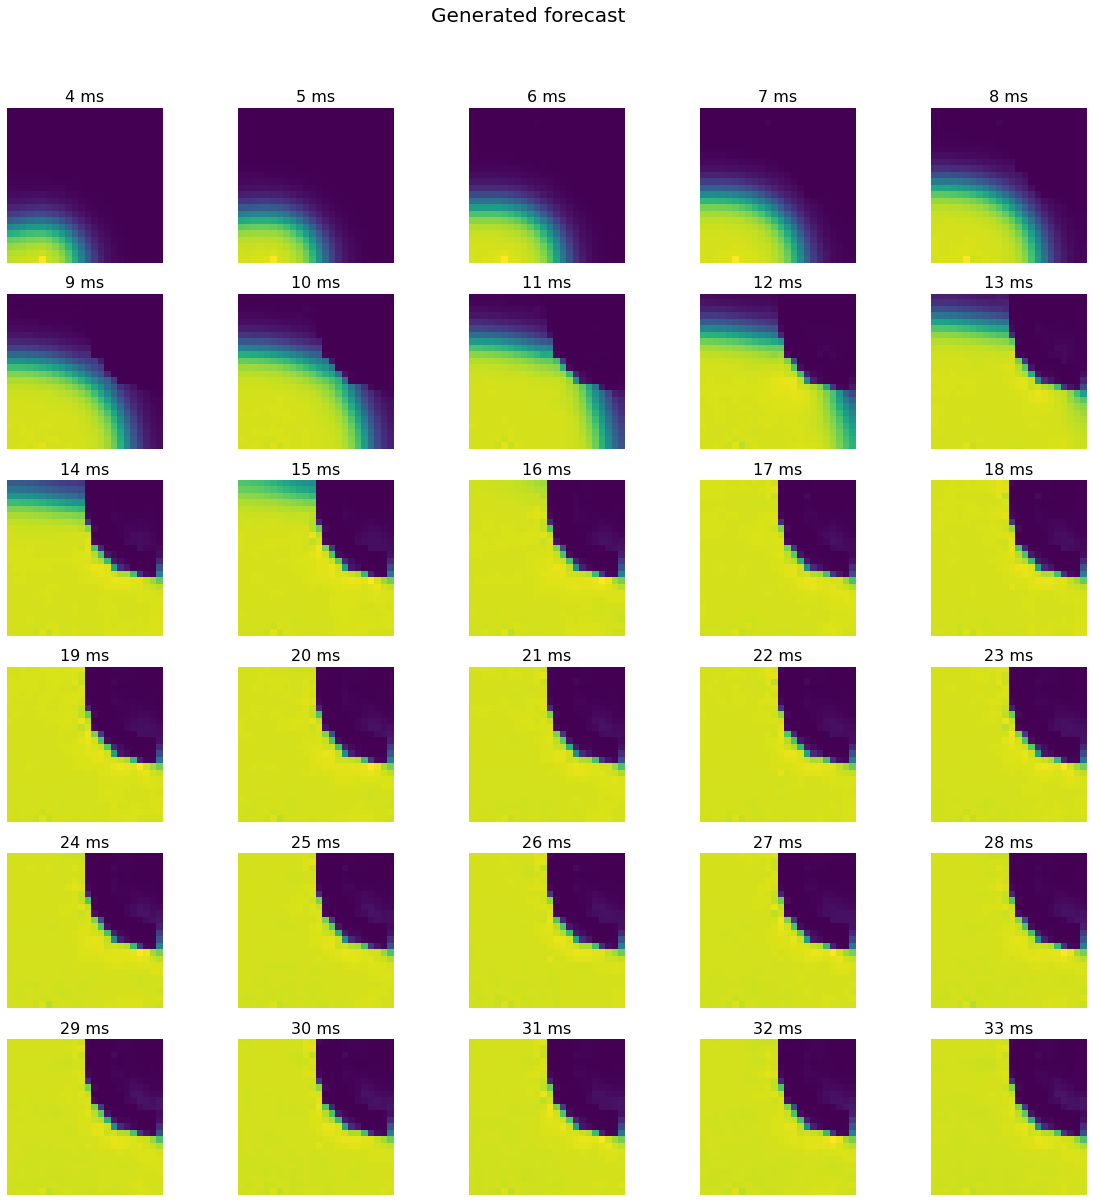

In [10]:
test_forecast_fake_new = generate_forecast(new_mask, test_frames_input_new,
                                           NN_psi, time_forecast=30)

plot_imgs(test_forecast_fake_new, nb_col = 5, figsize = (20,20), normaliz = 'norm', 
          title='Generated forecast', start_fr=start_fr_new+4)